In [2]:
# import GPUtil
# GPUtil.showUtilization()

# CAPSTONE - CNN, Keras, VGG16, ResNet50, MobileNetV2, InceptionV3

# Introduction

https://pyimagesearch.com/2019/05/20/transfer-learning-with-keras-and-deep-learning/
In general, there are two types of transfer learning in the context of deep learning:

Transfer learning via feature extraction
Transfer learning via fine-tuning

When performing feature extraction, we treat the pre-trained network as an arbitrary feature extractor, allowing the input image to propagate forward, stopping at pre-specified layer, and taking the outputs of that layer as our features.

Fine-tuning, on the other hand, requires that we update the model architecture itself by removing the previous fully-connected layer heads, providing new, freshly initialized ones, and then training the new FC layers to predict our input classes.

In [52]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                               
import tensorflow as tf                
from tqdm import tqdm

In [6]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

In [7]:
nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

## load data

In [8]:
def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.
    """
    
    datasets = ['data/seg_train', 'data/seg_test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                if np.shape(image) != ():
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image = cv2.resize(image, IMAGE_SIZE) 

                    # Append the image and its corresponding label to the output
                    images.append(image)
                    labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [9]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading data/seg_train


100%|██████████| 2404/2404 [00:08<00:00, 295.94it/s]


Loading data/seg_test


100%|██████████| 553/553 [00:01<00:00, 294.89it/s]


In [10]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

## scale data

In [11]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

## Exploration

In [54]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 14034
Number of testing examples: 3000
Each image is of size: (150, 150)


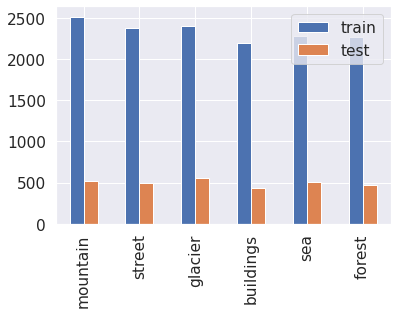

In [55]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

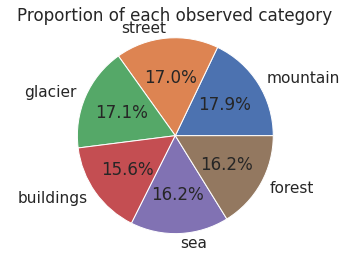

In [56]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

## Vizualize

In [57]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

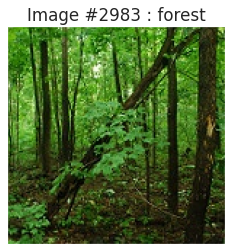

In [81]:
display_random_image(class_names, train_images, train_labels)

### display example

In [61]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

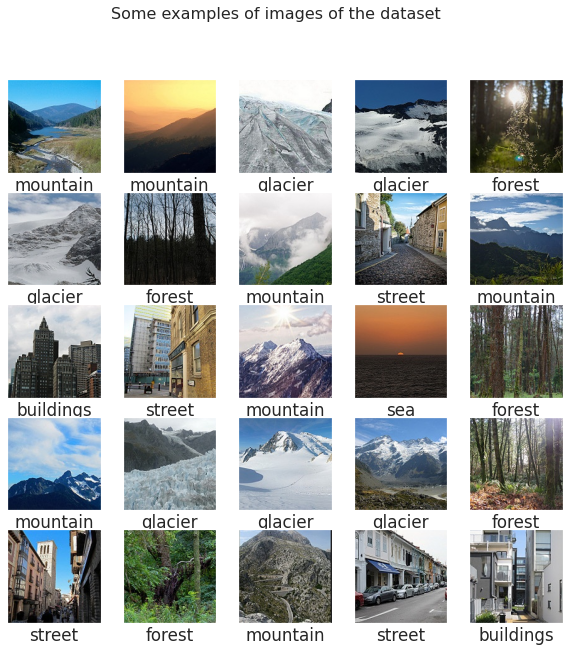

In [63]:
display_examples(class_names, train_images, train_labels)

# CNN - ACCURACY 0.767

In [65]:
model_cnn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

In [66]:
model_cnn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_94 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 41472)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               5308544   
_________________________________________________________________
dense_9 (Dense)              (None, 6)                

In [67]:
model_cnn.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [68]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_accuracy vs val_accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

In [69]:
history = model_cnn.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2)

Epoch 1/20
88/88 [==============================] - 9s 56ms/step - loss: 1.3303 - accuracy: 0.5299 - val_loss: 0.8945 - val_accuracy: 0.6705
Epoch 2/20
88/88 [==============================] - 3s 31ms/step - loss: 0.7915 - accuracy: 0.7132 - val_loss: 0.7385 - val_accuracy: 0.7339
Epoch 3/20
88/88 [==============================] - 3s 29ms/step - loss: 0.6093 - accuracy: 0.7856 - val_loss: 0.6523 - val_accuracy: 0.7681
Epoch 4/20
88/88 [==============================] - 3s 30ms/step - loss: 0.4905 - accuracy: 0.8284 - val_loss: 0.6411 - val_accuracy: 0.7748
Epoch 5/20
88/88 [==============================] - 2s 27ms/step - loss: 0.3893 - accuracy: 0.8730 - val_loss: 0.6364 - val_accuracy: 0.7752
Epoch 6/20
88/88 [==============================] - 2s 27ms/step - loss: 0.3456 - accuracy: 0.8865 - val_loss: 0.6321 - val_accuracy: 0.7781
Epoch 7/20
88/88 [==============================] - 2s 27ms/step - loss: 0.2640 - accuracy: 0.9141 - val_loss: 0.7278 - val_accuracy: 0.7752
Epoch 8/20
88

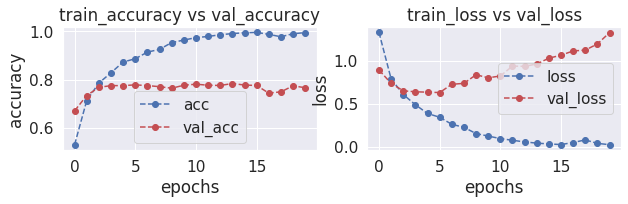

In [70]:
plot_accuracy_loss(history)

In [71]:
test_loss_cnn = model_cnn.evaluate(test_images, test_labels)

94/94 [==============================] - 1s 7ms/step - loss: 1.2975 - accuracy: 0.7673


In [72]:
predictions_cnn = model_cnn.predict(test_images)     # Vector of probabilities

In [73]:
pred_labels_cnn = np.argmax(predictions_cnn, axis = 1) # We take the highest probability

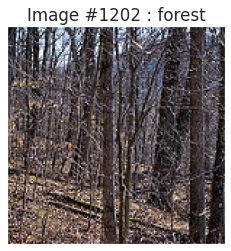

In [86]:
display_random_image(class_names, test_images, pred_labels_cnn)

### errors

In [75]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)


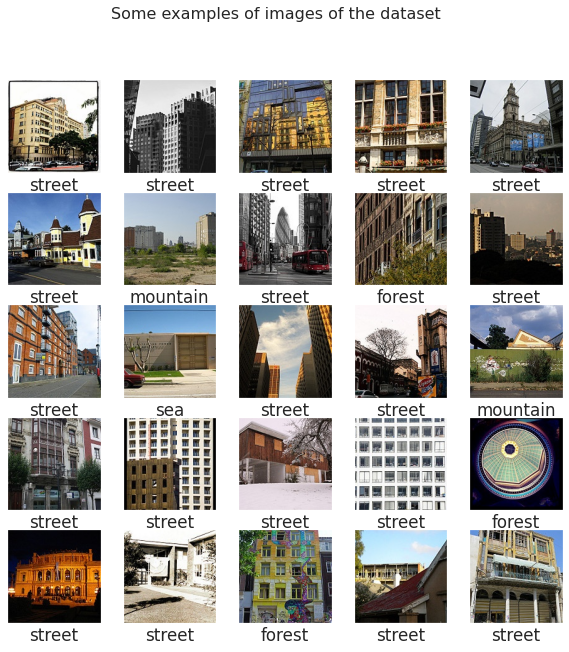

In [83]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels_cnn)

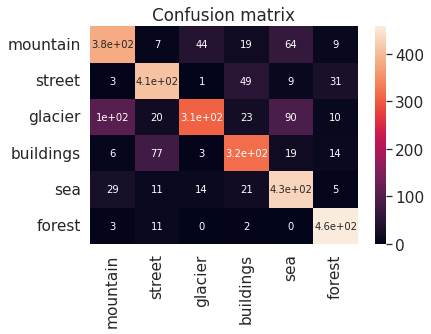

In [84]:
CM = confusion_matrix(test_labels, pred_labels_cnn)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

In [ ]:
# ******************** NOTE *****************************

# how to read the confusion matrix:
# https://www.analyticsvidhya.com/blog/2021/06/confusion-matrix-for-multi-class-classification/
# False NEGATIVE = sum over all cells in row except the the value for the class
# False POSITIVE = sum over all cells in column except the the value for the class

### Conclusion: The classifier has trouble with the following of images.
It has trouble with street and buildings. Understandable as there are buildings in the street. 
It has trouble with sea, glacier and moutain.
However, it can detects forest very accurately!

# Transfer Learning with VGG16, ResNet50, MobileNetV2,InceptionV3, EfficientNet

## VGG16 - Visual Geometry Group CNN 16 layers deep

In [17]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

model_vgg = VGG16(weights='imagenet', include_top=False)

In [18]:
train_features_vgg = model_vgg.predict(train_images)
test_features_vgg = model_vgg.predict(test_images)

In [19]:
train_features_vgg.shape

(14034, 4, 4, 512)

In [20]:
test_features_vgg.shape

(3000, 4, 4, 512)

In [21]:
n_train, xv, yv, zv = train_features_vgg.shape

### Transfer Training on VGG16 - ACCURACY 0.877

In [22]:
model_transfer_vgg = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (xv, yv, zv)),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model_transfer_vgg.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

history_transfer_vgg = model_transfer_vgg.fit(train_features_vgg, train_labels, batch_size=128, epochs=15, validation_split = 0.2)

Epoch 1/15
88/88 [==============================] - 1s 5ms/step - loss: 0.5321 - accuracy: 0.8006 - val_loss: 0.3639 - val_accuracy: 0.8685
Epoch 2/15
88/88 [==============================] - 0s 3ms/step - loss: 0.3077 - accuracy: 0.8914 - val_loss: 0.3325 - val_accuracy: 0.8778
Epoch 3/15
88/88 [==============================] - 0s 5ms/step - loss: 0.2420 - accuracy: 0.9155 - val_loss: 0.3255 - val_accuracy: 0.8799
Epoch 4/15
88/88 [==============================] - 0s 3ms/step - loss: 0.2062 - accuracy: 0.9295 - val_loss: 0.3458 - val_accuracy: 0.8750
Epoch 5/15
88/88 [==============================] - 0s 3ms/step - loss: 0.1698 - accuracy: 0.9427 - val_loss: 0.3420 - val_accuracy: 0.8789
Epoch 6/15
88/88 [==============================] - 0s 3ms/step - loss: 0.1452 - accuracy: 0.9528 - val_loss: 0.3465 - val_accuracy: 0.8796
Epoch 7/15
88/88 [==============================] - 0s 3ms/step - loss: 0.1182 - accuracy: 0.9649 - val_loss: 0.3523 - val_accuracy: 0.8753
Epoch 8/15
88/88 [==

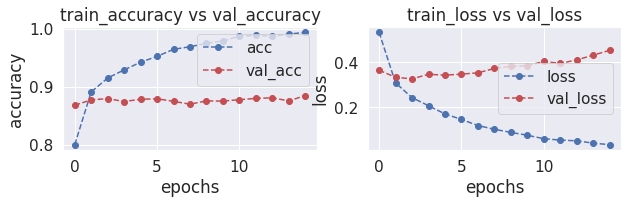

In [23]:
plot_accuracy_loss(history_transfer_vgg)

In [24]:
test_loss_vgg = model_transfer_vgg.evaluate(test_features_vgg, test_labels)

94/94 [==============================] - 0s 1ms/step - loss: 0.4517 - accuracy: 0.8773


In [25]:
from sklearn.metrics import accuracy_score

predictions_vgg = model_transfer_vgg.predict(test_features_vgg)    
pred_labels_vgg = np.argmax(predictions_vgg, axis = 1)
print("Accuracy : {}".format(accuracy_score(test_labels, pred_labels_vgg)))

Accuracy : 0.8773333333333333


### Fine-tuning VGG16 - ACCURACY 0.903

In [29]:
from keras.models import Model
model_feat = VGG16(weights='imagenet', include_top=False)
#model_feat = VGG16(weights='imagenet')

In [30]:
model_feat = Model(inputs=model_feat.inputs, outputs=model_feat.layers[-5].output)

In [31]:
train_features_feat = model_feat.predict(train_images)
test_features_feat = model_feat.predict(test_images)

In [32]:
from keras.layers import Input, Dense, Conv2D, Activation, MaxPooling2D, Flatten, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping

model_vft = VGG16(weights='imagenet', include_top=False)

In [33]:
train_features_feat.shape

(14034, 9, 9, 512)

In [34]:
# since input to this model is the features you trained on the VGG model
layer_input = Input(shape = (9, 9, 512)) 
    # a new input tensor to be able to feed the desired layer  -- is this correct?
#layer_input = Input(shape = input_shape)
# https://stackoverflow.com/questions/52800025/keras-give-input-to-intermediate-layer-and-get-final-output

In [35]:
x = layer_input
for layer in model_vft.layers[-4::1]:
    x = layer(x)
    
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dense(100,activation='relu')(x)
x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(6,activation='softmax')(x)    

# create the model
final_model = Model(layer_input, x)

In [36]:
final_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
final_model.summary()

In [37]:
history_vft = final_model.fit(train_features_feat, train_labels, batch_size=128, epochs=15, validation_split = 0.2)

Epoch 1/15
88/88 [==============================] - 4s 36ms/step - loss: 0.6535 - accuracy: 0.7467 - val_loss: 0.4098 - val_accuracy: 0.8561
Epoch 2/15
88/88 [==============================] - 2s 25ms/step - loss: 0.3249 - accuracy: 0.8888 - val_loss: 0.3191 - val_accuracy: 0.8924
Epoch 3/15
88/88 [==============================] - 2s 24ms/step - loss: 0.2695 - accuracy: 0.9102 - val_loss: 0.3070 - val_accuracy: 0.8967
Epoch 4/15
88/88 [==============================] - 2s 25ms/step - loss: 0.2212 - accuracy: 0.9257 - val_loss: 0.2970 - val_accuracy: 0.8985
Epoch 5/15
88/88 [==============================] - 2s 25ms/step - loss: 0.1894 - accuracy: 0.9345 - val_loss: 0.3181 - val_accuracy: 0.8931
Epoch 6/15
88/88 [==============================] - 2s 24ms/step - loss: 0.1537 - accuracy: 0.9497 - val_loss: 0.3454 - val_accuracy: 0.8764
Epoch 7/15
88/88 [==============================] - 2s 25ms/step - loss: 0.1425 - accuracy: 0.9524 - val_loss: 0.3139 - val_accuracy: 0.9081
Epoch 8/15
88

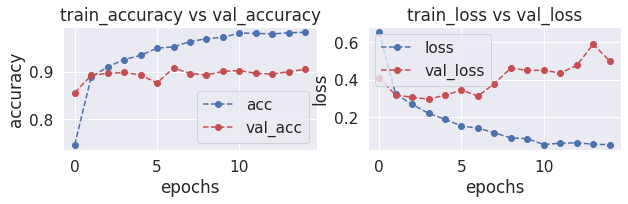

In [38]:
plot_accuracy_loss(history_vft)

In [39]:
from sklearn.metrics import accuracy_score

predictions = final_model.predict(test_features_feat)    
pred_labels = np.argmax(predictions, axis = 1)
print("Accuracy : {}".format(accuracy_score(test_labels, pred_labels)))

Accuracy : 0.903


### Try callbacks & different optimizer - ACCURACY 0.895

In [40]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

x = layer_input
for layer in model_vft.layers[-4::1]:
    x = layer(x)
    
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dense(100,activation='relu')(x)
x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(6,activation='softmax')(x)    

# create the model
final2_model = Model(layer_input, x)

# final2_model.compile(loss="categorical_crossentropy", metrics=["accuracy"],
#               optimizer=SGD(learning_rate=0.02, momentum=0.9,     
#                             nesterov=True, decay=0.001))

final2_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
              optimizer = 'adam')

# avoid overfitting
#cp = ModelCheckpoint('./intel_modelnetv2.h5', save_best_only=True)
es = EarlyStopping(patience=5, monitor='val_loss')

In [41]:
history_vft2 = final2_model.fit(train_features_feat, train_labels, batch_size=128, epochs=15, callbacks=[es],validation_split = 0.3)

#history_vft2 = final2_model.fit(train_features_feat, train_labels, batch_size=128, epochs=15,validation_split = 0.2)

Epoch 1/15
77/77 [==============================] - 4s 41ms/step - loss: 0.2158 - accuracy: 0.9438 - val_loss: 0.4042 - val_accuracy: 0.9316
Epoch 2/15
77/77 [==============================] - 2s 26ms/step - loss: 0.0504 - accuracy: 0.9855 - val_loss: 0.4470 - val_accuracy: 0.9271
Epoch 3/15
77/77 [==============================] - 2s 26ms/step - loss: 0.0540 - accuracy: 0.9850 - val_loss: 0.4223 - val_accuracy: 0.9311
Epoch 4/15
77/77 [==============================] - 2s 27ms/step - loss: 0.0541 - accuracy: 0.9855 - val_loss: 0.6331 - val_accuracy: 0.9081
Epoch 5/15
77/77 [==============================] - 2s 26ms/step - loss: 0.0361 - accuracy: 0.9904 - val_loss: 0.5902 - val_accuracy: 0.9195
Epoch 6/15
77/77 [==============================] - 2s 26ms/step - loss: 0.0300 - accuracy: 0.9916 - val_loss: 0.5166 - val_accuracy: 0.9276


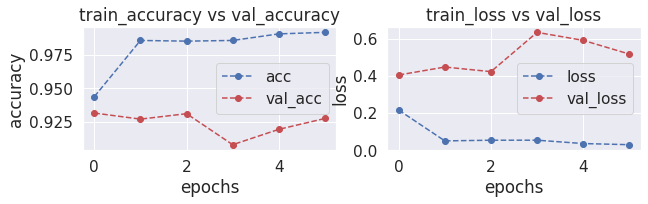

In [43]:
plot_accuracy_loss(history_vft2)

In [42]:
from sklearn.metrics import accuracy_score

predictions_vft2 = final2_model.predict(test_features_feat)    
pred_labels_vft2 = np.argmax(predictions_vft2, axis = 1)
print("Accuracy : {}".format(accuracy_score(test_labels, pred_labels_vft2)))

Accuracy : 0.8953333333333333


## ResNet50 - 50 layers deep - ACCURACY 0.627

In [2]:
from tensorflow.keras.applications.resnet50 import ResNet50
#from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [3]:
model_resnet = ResNet50(weights='imagenet', include_top=False)

In [12]:
train_features_res = model_resnet.predict(train_images)
test_features_res = model_resnet.predict(test_images)

In [13]:
train_features_res.shape

(14034, 5, 5, 2048)

In [14]:
test_features_res.shape

(3000, 5, 5, 2048)

In [15]:
n_train_r, xr, yr, zr = train_features_res.shape

### Transfer Training on ResNet50

In [16]:
model_transfer_res = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (xr, yr, zr)),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    #tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model_transfer_res.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
#model_transfer_res.compile(optimizer = 'momentum', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

history_transfer_res = model_transfer_res.fit(train_features_res, train_labels, batch_size=128, epochs=10, validation_split = 0.2)

Epoch 1/10
Extension horovod.torch has not been built: /usr/local/lib/python3.8/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-38-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2022-12-13 09:58:08.811 tensorflow-2-6-gpu--ml-g5-48xlarge-4b15d964dfc862c29c49f299b292:30496 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-12-13 09:58:08.836 tensorflow-2-6-gpu--ml-g5-48xlarge-4b15d964dfc862c29c49f299b292:30496 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
88/88 [==============================] - 2s 12ms/step - loss: 1.8303 - accuracy: 0.2889 - val_loss: 1.5436 - val_accuracy: 0.4503
Epoch 2/10
88/88 [==============================] - 1s 6ms/step - loss: 1.4071 - accuracy: 0.4381 - val_loss: 1.2344 - val_accuracy: 0.5248
Epoch 3/10
88/88 [=====

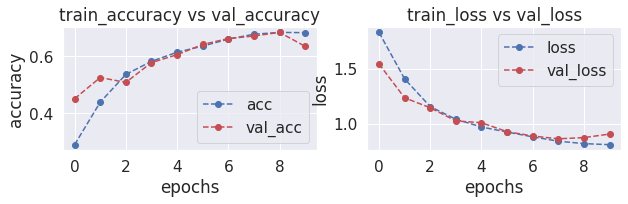

In [19]:
plot_accuracy_loss(history_transfer_res)

In [20]:
test_loss_res = model_transfer_res.evaluate(test_features_res, test_labels)

94/94 [==============================] - 0s 2ms/step - loss: 0.9272 - accuracy: 0.6277


In [21]:
from sklearn.metrics import accuracy_score

predictions_res = model_transfer_res.predict(test_features_res)    
pred_labels_res = np.argmax(predictions_res, axis = 1)
print("Accuracy : {}".format(accuracy_score(test_labels, pred_labels_res)))

Accuracy : 0.6276666666666667


## MobileNetv2 - 53 layers deep - ACCURACY 0.91

In [22]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
#from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions

In [23]:
model_mobnet = MobileNetV2(weights='imagenet', include_top=False)

In [24]:
train_features_mob = model_mobnet.predict(train_images)
test_features_mob = model_mobnet.predict(test_images)

In [25]:
train_features_mob.shape

(14034, 4, 4, 1280)

In [26]:
test_features_mob.shape

(3000, 4, 4, 1280)

In [27]:
n_train_m, xm, ym, zm = train_features_mob.shape

### Transfer Training on MobileNetV2

In [28]:
model_transfer_mob = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (xm, ym, zm)),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model_transfer_mob.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

history_transfer_mob = model_transfer_mob.fit(train_features_mob, train_labels, batch_size=128, epochs=15, validation_split = 0.2)

Epoch 1/15
88/88 [==============================] - 1s 5ms/step - loss: 0.6201 - accuracy: 0.8479 - val_loss: 0.3090 - val_accuracy: 0.8928
Epoch 2/15
88/88 [==============================] - 0s 3ms/step - loss: 0.2145 - accuracy: 0.9243 - val_loss: 0.3269 - val_accuracy: 0.8938
Epoch 3/15
88/88 [==============================] - 0s 3ms/step - loss: 0.1226 - accuracy: 0.9558 - val_loss: 0.3064 - val_accuracy: 0.9035
Epoch 4/15
88/88 [==============================] - 0s 3ms/step - loss: 0.0798 - accuracy: 0.9731 - val_loss: 0.3404 - val_accuracy: 0.8864
Epoch 5/15
88/88 [==============================] - 0s 3ms/step - loss: 0.0572 - accuracy: 0.9817 - val_loss: 0.3138 - val_accuracy: 0.9038
Epoch 6/15
88/88 [==============================] - 0s 3ms/step - loss: 0.0370 - accuracy: 0.9892 - val_loss: 0.3596 - val_accuracy: 0.9002
Epoch 7/15
88/88 [==============================] - 0s 3ms/step - loss: 0.0227 - accuracy: 0.9954 - val_loss: 0.3883 - val_accuracy: 0.9027
Epoch 8/15
88/88 [==

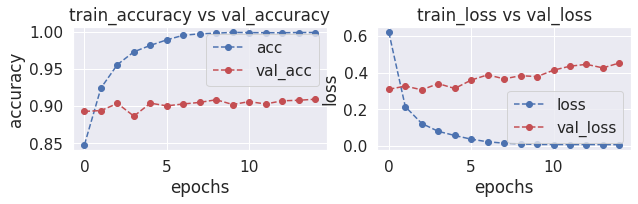

In [29]:
plot_accuracy_loss(history_transfer_mob)

In [30]:
test_loss_mob = model_transfer_mob.evaluate(test_features_mob, test_labels)

94/94 [==============================] - 0s 1ms/step - loss: 0.3960 - accuracy: 0.9130


In [31]:
from sklearn.metrics import accuracy_score

predictions_mob = model_transfer_mob.predict(test_features_mob)    
pred_labels_mob = np.argmax(predictions_mob, axis = 1)
print("Accuracy : {}".format(accuracy_score(test_labels, pred_labels_mob)))

Accuracy : 0.913


## InceptionV3 - 48 layers deep - ACCURACY 0.891

In [32]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [33]:
model_incep = InceptionV3(weights='imagenet', include_top=False)

In [34]:
train_features_ince = model_incep.predict(train_images)
test_features_ince = model_incep.predict(test_images)

In [35]:
train_features_ince.shape

(14034, 3, 3, 2048)

In [36]:
test_features_ince.shape

(3000, 3, 3, 2048)

In [37]:
n_train_i, xc, yc, zc = train_features_ince.shape

### Transfer Training with InceptionV3

In [38]:
model_transfer_ince = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (xc, yc, zc)),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model_transfer_ince.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

history_transfer_ince = model_transfer_ince.fit(train_features_ince, train_labels, batch_size=128, epochs=15, validation_split = 0.2)

Epoch 1/15
88/88 [==============================] - 1s 5ms/step - loss: 0.9652 - accuracy: 0.7745 - val_loss: 0.3683 - val_accuracy: 0.8764
Epoch 2/15
88/88 [==============================] - 0s 3ms/step - loss: 0.2965 - accuracy: 0.8979 - val_loss: 0.3290 - val_accuracy: 0.8864
Epoch 3/15
88/88 [==============================] - 0s 3ms/step - loss: 0.2339 - accuracy: 0.9189 - val_loss: 0.3265 - val_accuracy: 0.8896
Epoch 4/15
88/88 [==============================] - 0s 3ms/step - loss: 0.1807 - accuracy: 0.9367 - val_loss: 0.3169 - val_accuracy: 0.8960
Epoch 5/15
88/88 [==============================] - 0s 3ms/step - loss: 0.1459 - accuracy: 0.9504 - val_loss: 0.3520 - val_accuracy: 0.8846
Epoch 6/15
88/88 [==============================] - 0s 3ms/step - loss: 0.1140 - accuracy: 0.9610 - val_loss: 0.3263 - val_accuracy: 0.8974
Epoch 7/15
88/88 [==============================] - 0s 3ms/step - loss: 0.0930 - accuracy: 0.9691 - val_loss: 0.3627 - val_accuracy: 0.8935
Epoch 8/15
88/88 [==

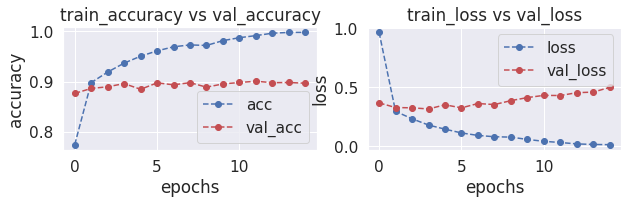

In [39]:
plot_accuracy_loss(history_transfer_ince)

In [40]:
test_loss_ince = model_transfer_ince.evaluate(test_features_ince, test_labels)

94/94 [==============================] - 0s 1ms/step - loss: 0.4669 - accuracy: 0.8910


In [41]:
from sklearn.metrics import accuracy_score

predictions_ince = model_transfer_ince.predict(test_features_ince)    
pred_labels_ince = np.argmax(predictions_ince, axis = 1)
print("Accuracy : {}".format(accuracy_score(test_labels, pred_labels_ince)))

Accuracy : 0.891


## EfficientNetB1 > 230 layers deep - ACCURACY 0.175 ?!

In [79]:
# tf.keras.applications.EfficientNetV2L(
#     include_top=True,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=None,
#     pooling=None,
#     classes=1000,
#     classifier_activation="softmax",
#     include_preprocessing=True,
# )

In [42]:
model_enet = tf.keras.applications.EfficientNetB7(weights='imagenet', include_top=False)

In [43]:
train_features_enet = model_enet.predict(train_images)
test_features_enet = model_enet.predict(test_images)

In [44]:
train_features_enet.shape

(14034, 4, 4, 2560)

In [45]:
test_features_enet.shape

(3000, 4, 4, 2560)

In [46]:
n_train_i, xe, ye, ze = train_features_enet.shape

In [47]:
model_transfer_enet = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (xe, ye, ze)),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model_transfer_enet.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

history_transfer_enet = model_transfer_enet.fit(train_features_enet, train_labels, batch_size=128, epochs=15, validation_split = 0.2)

Epoch 1/15
88/88 [==============================] - 1s 11ms/step - loss: 3.6181 - accuracy: 0.1652 - val_loss: 1.7918 - val_accuracy: 0.1760
Epoch 2/15
88/88 [==============================] - 0s 5ms/step - loss: 1.7917 - accuracy: 0.1682 - val_loss: 1.7914 - val_accuracy: 0.1760
Epoch 3/15
88/88 [==============================] - 0s 6ms/step - loss: 1.7914 - accuracy: 0.1760 - val_loss: 1.7912 - val_accuracy: 0.1753
Epoch 4/15
88/88 [==============================] - 0s 5ms/step - loss: 1.7912 - accuracy: 0.1799 - val_loss: 1.7910 - val_accuracy: 0.1753
Epoch 5/15
88/88 [==============================] - 1s 6ms/step - loss: 1.7910 - accuracy: 0.1799 - val_loss: 1.7909 - val_accuracy: 0.1753
Epoch 6/15
88/88 [==============================] - 1s 6ms/step - loss: 1.7909 - accuracy: 0.1799 - val_loss: 1.7908 - val_accuracy: 0.1753
Epoch 7/15
88/88 [==============================] - 0s 6ms/step - loss: 1.7909 - accuracy: 0.1799 - val_loss: 1.7908 - val_accuracy: 0.1753
Epoch 8/15
88/88 [=

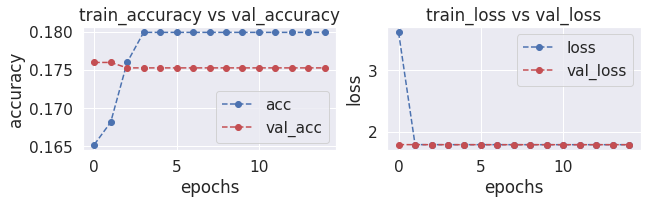

In [48]:
plot_accuracy_loss(history_transfer_enet)

In [49]:
test_loss_enet = model_transfer_enet.evaluate(test_features_enet, test_labels)

94/94 [==============================] - 0s 2ms/step - loss: 1.7902 - accuracy: 0.1750


In [50]:
from sklearn.metrics import accuracy_score

predictions_enet = model_transfer_enet.predict(test_features_enet)    
pred_labels_enet = np.argmax(predictions_enet, axis = 1)
print("Accuracy : {}".format(accuracy_score(test_labels, pred_labels_enet)))

Accuracy : 0.175
